# Baseline 01


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from pathlib import Path

# Reproducibility: fix a global random seed
RNG = np.random.default_rng(42)

# Nominal confidence level
ALPHA = 0.05  # 95% CI



In [5]:
# We want a robust path setup so the notebook can be run from anywhere.
# The project root is the parent folder of "notebooks".

project_root = Path.cwd()

# If you're running this from within notebooks/, project_root should be one level up.
# We'll detect and fix it if needed.
if project_root.name == "notebooks":
    project_root = project_root.parent

figures_dir = project_root / "results" / "figures"
figures_dir.mkdir(parents=True, exist_ok=True)

print("Project root:", project_root)
print("Figures will be saved to:", figures_dir)


Project root: c:\Users\Ziqian Wang\Desktop\William\IMPERIAL\YEAR 2\cw_rl_ci
Figures will be saved to: c:\Users\Ziqian Wang\Desktop\William\IMPERIAL\YEAR 2\cw_rl_ci\results\figures


In [6]:
def iid_returns(n: int, mu: float, sigma: float, rng: np.random.Generator) -> np.ndarray:
    """
    Generate IID episode returns: R_i ~ Normal(mu, sigma^2), independent across i.

    In RL language:
    - Each sample corresponds to a fresh "episode reset"
    - Returns are independent across episodes (idealized assumption)
    """
    return rng.normal(loc=mu, scale=sigma, size=n)


def correlated_returns_ar1(n: int, mu: float, sigma: float, rho: float, rng: np.random.Generator) -> np.ndarray:
    """
    Generate correlated returns via a stationary AR(1) process to mimic trajectory dependence.

    We generate:
        X_t = rho * X_{t-1} + eps_t
    where eps_t ~ Normal(0, sigma_eps^2), chosen so Var(X_t) = sigma^2 in stationarity.

    Then returns are:
        R_t = mu + X_t

    Interpretation:
    - When rho is large (e.g. 0.8~0.95), consecutive returns are strongly correlated.
    - This mimics the fact that trajectory data violate the iid assumption.

    Parameters
    ----------
    n : sample size
    mu : true mean return (the parameter V(pi))
    sigma : marginal standard deviation of returns
    rho : correlation strength in [0, 1)
    rng : random generator
    """
    if not (0 <= rho < 1):
        raise ValueError("rho must be in [0, 1).")

    # Choose innovation variance so that stationary Var(X_t) = sigma^2:
    # Var(X_t) = sigma_eps^2 / (1 - rho^2) => sigma_eps = sigma * sqrt(1 - rho^2)
    sigma_eps = sigma * np.sqrt(1 - rho**2)

    x = np.zeros(n, dtype=float)
    eps = rng.normal(0.0, sigma_eps, size=n)

    for t in range(1, n):
        x[t] = rho * x[t - 1] + eps[t]

    return mu + x


In [7]:
def mean_estimator(R: np.ndarray) -> float:
    """
    Sample mean estimator for V(pi) = E[R].

    This is the standard policy value estimator in on-policy Monte Carlo evaluation.
    """
    return float(np.mean(R))


def naive_wald_ci(R: np.ndarray, alpha: float = 0.05) -> tuple[float, float]:
    """
    Naive Wald confidence interval for mean return, assuming IID.

    CI = mean ± z_(1-alpha/2) * s/sqrt(n)

    WARNING:
    - This CI is theoretically justified under IID + CLT assumptions.
    - If returns are correlated, s/sqrt(n) underestimates the true standard error,
      often leading to under-coverage.
    """
    n = len(R)
    m = float(np.mean(R))
    s = float(np.std(R, ddof=1))  # sample std with Bessel correction
    z = float(norm.ppf(1 - alpha / 2))
    half_width = z * s / np.sqrt(n)
    return m - half_width, m + half_width


In [8]:
def moving_block_bootstrap_ci(
    R: np.ndarray,
    block_len: int,
    B: int = 300,
    alpha: float = 0.05,
    rng: np.random.Generator | None = None,
) -> tuple[float, float]:
    """
    Moving Block Bootstrap (MBB) CI for the mean under dependence.

    Idea:
    - If the data are dependent, naive resampling of individual points breaks dependence structure.
    - Instead, resample *contiguous blocks* of length L to preserve local dependence.

    Procedure:
    1) Consider all blocks R[s : s+L] for s = 0,1,...,n-L.
    2) Sample blocks with replacement and stitch them until we reach length n.
    3) Compute bootstrap mean for each bootstrap sample.
    4) CI is the (alpha/2, 1-alpha/2) quantiles of bootstrap means (percentile CI).

    Parameters
    ----------
    R : array of returns (length n)
    block_len : block length L (>=1 and <= n)
    B : number of bootstrap resamples
    alpha : significance level (0.05 -> 95% CI)
    rng : random generator

    Returns
    -------
    (low, high) : bootstrap percentile CI
    """
    if rng is None:
        rng = np.random.default_rng(0)

    n = len(R)
    L = int(block_len)
    if L < 1 or L > n:
        raise ValueError("block_len must be between 1 and n.")

    # Starting indices of all valid blocks
    starts = np.arange(0, n - L + 1)

    boot_means = np.empty(B, dtype=float)

    for b in range(B):
        resampled = []
        while len(resampled) < n:
            s = int(rng.choice(starts))
            resampled.extend(R[s : s + L])
        resampled = np.array(resampled[:n], dtype=float)
        boot_means[b] = np.mean(resampled)

    lo = float(np.quantile(boot_means, alpha / 2))
    hi = float(np.quantile(boot_means, 1 - alpha / 2))
    return lo, hi


In [9]:
def estimate_coverage(
    true_mu: float,
    sampler,
    n: int,
    M: int,
    ci_func,
    rng: np.random.Generator,
) -> float:
    """
    Estimate empirical coverage of a confidence interval procedure.

    We repeat M times:
      - sample returns R_1,...,R_n
      - compute CI = [L, U]
      - check whether true_mu lies in CI

    Coverage estimate:
      (1/M) * sum I{ true_mu in CI_m }
    """
    hits = 0
    for _ in range(M):
        R = sampler(n=n, rng=rng)
        lo, hi = ci_func(R)
        hits += int(lo <= true_mu <= hi)
    return hits / M


In [14]:
# True parameter (policy value), and noise scale
MU_TRUE = 0.5
SIGMA = 1.0

# Correlation strength for the "trajectory-like" regime
RHO = 0.8

# Sample sizes and number of Monte Carlo repetitions
NS = [20, 50, 100, 200]
M_REPS = 400

# Define samplers in a unified signature sampler(n, rng) -> array
sampler_iid = lambda n, rng: iid_returns(n=n, mu=MU_TRUE, sigma=SIGMA, rng=rng)
sampler_corr = lambda n, rng: correlated_returns_ar1(n=n, mu=MU_TRUE, sigma=SIGMA, rho=RHO, rng=rng)

# CI procedures
ci_naive = lambda R: naive_wald_ci(R, alpha=ALPHA)

def ci_block(R: np.ndarray) -> tuple[float, float]:
    """
    Choose a simple block length heuristic.
    Rule of thumb: L ~ n^(1/3). (Not optimal, but reasonable for a baseline.)
    """
    n = len(R)
    L = max(5, int(round(n ** (1/3))*2))
    return moving_block_bootstrap_ci(R, block_len=L, B=1000, alpha=ALPHA, rng=RNG)

# Run coverage estimation
cov_iid_naive = []
cov_corr_naive = []
cov_corr_block = []

for n in NS:
    c1 = estimate_coverage(MU_TRUE, sampler_iid, n, M_REPS, ci_naive, RNG)
    c2 = estimate_coverage(MU_TRUE, sampler_corr, n, M_REPS, ci_naive, RNG)
    c3 = estimate_coverage(MU_TRUE, sampler_corr, n, M_REPS, ci_block, RNG)

    cov_iid_naive.append(c1)
    cov_corr_naive.append(c2)
    cov_corr_block.append(c3)

    print(f"n={n:4d} | iid-naive={c1:.3f} | corr-naive={c2:.3f} | corr-block={c3:.3f}")


n=  20 | iid-naive=0.932 | corr-naive=0.432 | corr-block=0.497
n=  50 | iid-naive=0.960 | corr-naive=0.515 | corr-block=0.705
n= 100 | iid-naive=0.935 | corr-naive=0.465 | corr-block=0.795
n= 200 | iid-naive=0.948 | corr-naive=0.455 | corr-block=0.818


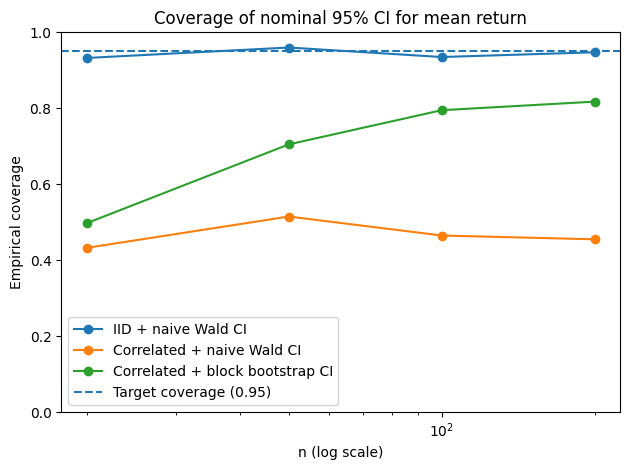

Saved figure to: c:\Users\Ziqian Wang\Desktop\William\IMPERIAL\YEAR 2\cw_rl_ci\results\figures\coverage.png


In [15]:
target = 1 - ALPHA

plt.figure()
plt.plot(NS, cov_iid_naive, marker="o", label="IID + naive Wald CI")
plt.plot(NS, cov_corr_naive, marker="o", label="Correlated + naive Wald CI")
plt.plot(NS, cov_corr_block, marker="o", label="Correlated + block bootstrap CI")
plt.axhline(target, linestyle="--", label=f"Target coverage ({target:.2f})")

plt.xscale("log")
plt.ylim(0.0, 1.0)
plt.xlabel("n (log scale)")
plt.ylabel("Empirical coverage")
plt.title("Coverage of nominal 95% CI for mean return")
plt.legend()
plt.tight_layout()

out_path = figures_dir / "coverage.png"
plt.savefig(out_path, dpi=200)
plt.show()

print("Saved figure to:", out_path)


In [11]:
# --- Sensitivity analysis: how correlation strength (rho) affects coverage ---

RHOS = [0.0, 0.5, 0.8, 0.95]
NS_SENS = [50, 100, 200]   # keep short to save time
M_NAIVE = 1500             # enough stability
M_BLOCK = 250              # bootstrap is expensive
BOOT_B = 400               # bootstrap resamples

def make_sampler_corr(rho_value: float):
    return lambda n, rng: correlated_returns_ar1(n=n, mu=MU_TRUE, sigma=SIGMA, rho=rho_value, rng=rng)

def ci_block_factory(B=BOOT_B):
    def _ci_block(R: np.ndarray):
        n = len(R)
        L = max(5, int(round(2 * (n ** (1/3)))))
        return moving_block_bootstrap_ci(R, block_len=L, B=B, alpha=ALPHA, rng=RNG)
    return _ci_block

ci_naive = lambda R: naive_wald_ci(R, alpha=ALPHA)
ci_block = ci_block_factory()

# Collect results in dicts: rho -> list of coverages across NS_SENS
cov_corr_naive_by_rho = {}
cov_corr_block_by_rho = {}

for rho_value in RHOS:
    sampler_corr_rho = make_sampler_corr(rho_value)

    cov_naive_list = []
    cov_block_list = []

    for n in NS_SENS:
        c_naive = estimate_coverage(MU_TRUE, sampler_corr_rho, n, M_NAIVE, ci_naive, RNG)
        c_block = estimate_coverage(MU_TRUE, sampler_corr_rho, n, M_BLOCK, ci_block, RNG)

        cov_naive_list.append(c_naive)
        cov_block_list.append(c_block)

    cov_corr_naive_by_rho[rho_value] = cov_naive_list
    cov_corr_block_by_rho[rho_value] = cov_block_list

    print(f"rho={rho_value:.2f} | naive={cov_naive_list} | block={cov_block_list}")


rho=0.00 | naive=[0.9446666666666667, 0.9526666666666667, 0.9453333333333334] | block=[0.892, 0.872, 0.916]
rho=0.50 | naive=[0.736, 0.7313333333333333, 0.7413333333333333] | block=[0.772, 0.88, 0.864]
rho=0.80 | naive=[0.462, 0.476, 0.49266666666666664] | block=[0.704, 0.808, 0.808]
rho=0.95 | naive=[0.21133333333333335, 0.22533333333333333, 0.24] | block=[0.468, 0.504, 0.596]


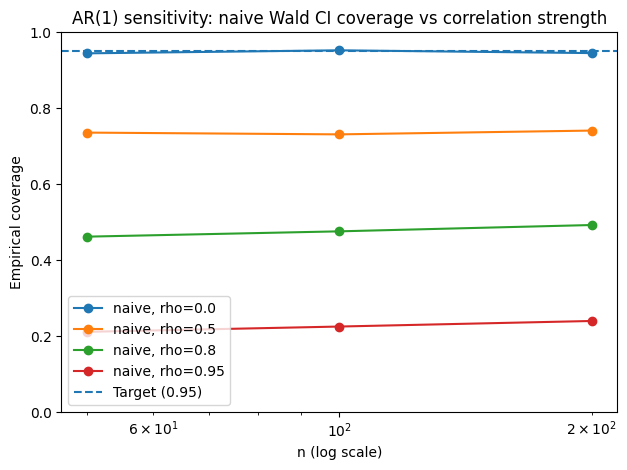

Saved: c:\Users\Ziqian Wang\Desktop\William\IMPERIAL\YEAR 2\cw_rl_ci\results\figures\baseline_sensitivity_naive_by_rho.png


In [12]:
target = 1 - ALPHA

plt.figure()
for rho_value in RHOS:
    plt.plot(NS_SENS, cov_corr_naive_by_rho[rho_value], marker="o", label=f"naive, rho={rho_value}")

plt.axhline(target, linestyle="--", label=f"Target ({target:.2f})")
plt.xscale("log")
plt.ylim(0.0, 1.0)
plt.xlabel("n (log scale)")
plt.ylabel("Empirical coverage")
plt.title("AR(1) sensitivity: naive Wald CI coverage vs correlation strength")
plt.legend()
plt.tight_layout()

out_path = figures_dir / "baseline_sensitivity_naive_by_rho.png"
plt.savefig(out_path, dpi=200)
plt.show()
print("Saved:", out_path)


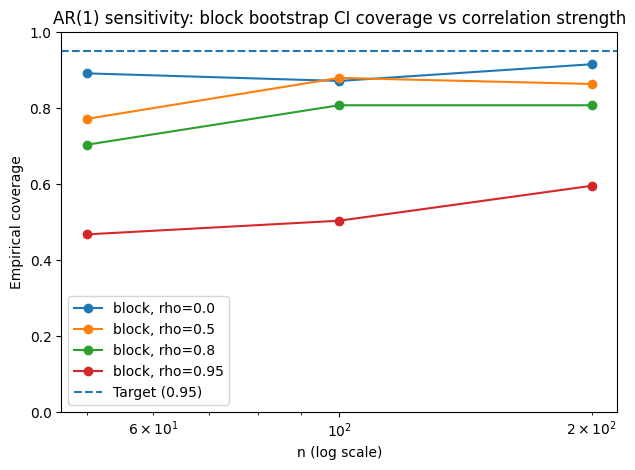

Saved: c:\Users\Ziqian Wang\Desktop\William\IMPERIAL\YEAR 2\cw_rl_ci\results\figures\baseline_sensitivity_block_by_rho.png


In [13]:
plt.figure()
for rho_value in RHOS:
    plt.plot(NS_SENS, cov_corr_block_by_rho[rho_value], marker="o", label=f"block, rho={rho_value}")

plt.axhline(target, linestyle="--", label=f"Target ({target:.2f})")
plt.xscale("log")
plt.ylim(0.0, 1.0)
plt.xlabel("n (log scale)")
plt.ylabel("Empirical coverage")
plt.title("AR(1) sensitivity: block bootstrap CI coverage vs correlation strength")
plt.legend()
plt.tight_layout()

out_path = figures_dir / "baseline_sensitivity_block_by_rho.png"
plt.savefig(out_path, dpi=200)
plt.show()
print("Saved:", out_path)


# Remark

One can change the value of rho to observe how it will behave under various settings. (TBD!)